In [ ]:
# *Import Necessaries*(Kebutuhan)

import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('we are currently using tensorflow version', tf.__version__)
print ('modules loaded')

In [ ]:
# Tentukan jalur data dan nama dataset
# jika menggunakan kaggle machine
data_dir = 'C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafBD Dataset'
ds_name = 'Penyakit Daun Mangga'

In [3]:
# Membuat *Dataframe* untuk dataset
# Membuat jalur data dengan label

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [4]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)

In [5]:
df.head(10)

filepaths       labels
0  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
1  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
2  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
3  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
4  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
5  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
6  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
7  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
8  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
9  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose

In [6]:
# Menampilkan Jumlah Contoh dalam dataset

def num_of_examples(df, name='df'):
    print(f"jumlah gambar {name} memiliki sebanyak {df.shape[0]} gambar.")

num_of_examples(df, ds_name)

jumlah gambar Penyakit Daun Mangga memiliki sebanyak 4000 gambar.


In [7]:
# Menampilkan Jumlah Kelas dalam dataset

def num_of_classes(df, name='df'):
    print(f"jumlah jenis {name} memiliki {len(df['labels'].unique())} jenis penyakit")

num_of_classes(df, ds_name)

jumlah jenis Penyakit Daun Mangga memiliki 8 jenis penyakit


In [8]:
# Menampilkan jumlah gambar di setiap kelas dataset

def classes_count(df, name='df'):

    print(f"jenis {name} pada dataset sebagai berikut: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"jenis '{name}' memiliki {num_class} gambar")
        print('-'*70)

classes_count(df, ds_name)

jenis Penyakit Daun Mangga pada dataset sebagai berikut: 

jenis 'Anthracnose' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Bacterial Canker' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Cutting Weevil' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Die Back' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Gall Midge' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Healthy' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Powdery Mildew' memiliki 500 gambar
----------------------------------------------------------------------
jenis 'Sooty Mould' memiliki 500 gambar
----------------------------------------------------------------------


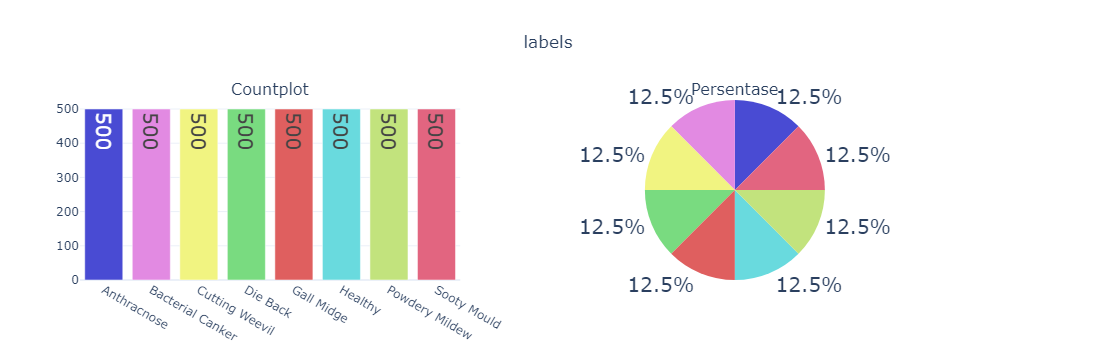

In [9]:
# Memvisualisasikan Setiap Kelas dalam dataset

def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Persentase'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

In [10]:
# Memeriksa nilai *Null* dalam *dataframe*

def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"dataset {name} tidak memiliki nilai null")

    else:
        print(f"Dataset {name} memiliki {num_null_vals} niali null")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

dataset Penyakit Daun Mangga tidak memiliki nilai null


In [11]:
 # Memvisualisasikan nilai *Null*

msno.matrix(df)
plt.title('Distribusi Nilai yang Hilang/Missing Values', fontsize=30, fontstyle='oblique');

NameError: name 'msno' is not defined

In [12]:
# Membagi(*split*) *dataframe* menjadi data *train*(latih), *valid*, dan tes

In [13]:
df.head(10)

filepaths       labels
0  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
1  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
2  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
3  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
4  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
5  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
6  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
7  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
8  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose
9  C:/Users/USER/PM/PROJECT ML/dataset/MangoLeafB...  Anthracnose

In [14]:
# train(latih) dataframe dengan perbanding 70:30 (70% data untuk train dan 30% untuk validasi dan testing)
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and tes dataframe 30% sisa data di bagi lagi menjadi 50:50 untuk validasi dan testing
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [15]:
def num_imgs(df, name='df'):
    print(f"Jumlah data {name} ada sebanyak {len(df)} gambar")

In [16]:
num_imgs(train_df, 'Training '+ds_name)
num_imgs(valid_df, 'Validation '+ds_name)
num_imgs(test_df, 'Testing '+ds_name)

Jumlah data Training Penyakit Daun Mangga ada sebanyak 2800 gambar
Jumlah data Validation Penyakit Daun Mangga ada sebanyak 600 gambar
Jumlah data Testing Penyakit Daun Mangga ada sebanyak 600 gambar


In [17]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

jumlah jenis Training Penyakit Daun Mangga memiliki 8 jenis penyakit
jumlah jenis Validation Penyakit Daun Mangga memiliki 8 jenis penyakit
jumlah jenis Testing Penyakit Daun Mangga memiliki 8 jenis penyakit


In [18]:
classes_count(train_df, 'Training '+ds_name)

jenis Training Penyakit Daun Mangga pada dataset sebagai berikut: 

jenis 'Die Back' memiliki 354 gambar
----------------------------------------------------------------------
jenis 'Powdery Mildew' memiliki 353 gambar
----------------------------------------------------------------------
jenis 'Cutting Weevil' memiliki 348 gambar
----------------------------------------------------------------------
jenis 'Anthracnose' memiliki 365 gambar
----------------------------------------------------------------------
jenis 'Gall Midge' memiliki 365 gambar
----------------------------------------------------------------------
jenis 'Sooty Mould' memiliki 343 gambar
----------------------------------------------------------------------
jenis 'Bacterial Canker' memiliki 322 gambar
----------------------------------------------------------------------
jenis 'Healthy' memiliki 350 gambar
----------------------------------------------------------------------


In [19]:
classes_count(valid_df, 'Validation '+ds_name)

jenis Validation Penyakit Daun Mangga pada dataset sebagai berikut: 

jenis 'Bacterial Canker' memiliki 95 gambar
----------------------------------------------------------------------
jenis 'Anthracnose' memiliki 70 gambar
----------------------------------------------------------------------
jenis 'Healthy' memiliki 75 gambar
----------------------------------------------------------------------
jenis 'Die Back' memiliki 67 gambar
----------------------------------------------------------------------
jenis 'Cutting Weevil' memiliki 78 gambar
----------------------------------------------------------------------
jenis 'Sooty Mould' memiliki 84 gambar
----------------------------------------------------------------------
jenis 'Powdery Mildew' memiliki 70 gambar
----------------------------------------------------------------------
jenis 'Gall Midge' memiliki 61 gambar
----------------------------------------------------------------------


In [20]:
classes_count(test_df, 'Testing '+ds_name)

jenis Testing Penyakit Daun Mangga pada dataset sebagai berikut: 

jenis 'Anthracnose' memiliki 65 gambar
----------------------------------------------------------------------
jenis 'Sooty Mould' memiliki 73 gambar
----------------------------------------------------------------------
jenis 'Cutting Weevil' memiliki 74 gambar
----------------------------------------------------------------------
jenis 'Bacterial Canker' memiliki 83 gambar
----------------------------------------------------------------------
jenis 'Die Back' memiliki 79 gambar
----------------------------------------------------------------------
jenis 'Healthy' memiliki 75 gambar
----------------------------------------------------------------------
jenis 'Powdery Mildew' memiliki 77 gambar
----------------------------------------------------------------------
jenis 'Gall Midge' memiliki 74 gambar
----------------------------------------------------------------------


In [21]:
# Membuat *Generator* Data Gambar

In [22]:
# ukuran gambar berselubung
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Direkomendasikan: gunakan fungsi khusus untuk ukuran batch data uji, jika tidak, kita dapat menggunakan ukuran batch normal.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Fungsi ini yang akan digunakan dalam generator data gambar untuk penambahan data, hanya mengambil gambar dan mengembalikannya lagi.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col = 'filepaths',
                                       y_col= 'labels',
                                       target_size = img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Catatan: kita akan menggunakan test_batch_size khusus, dan membuat shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


In [23]:
# Memvisualisasikan *dataset Training*

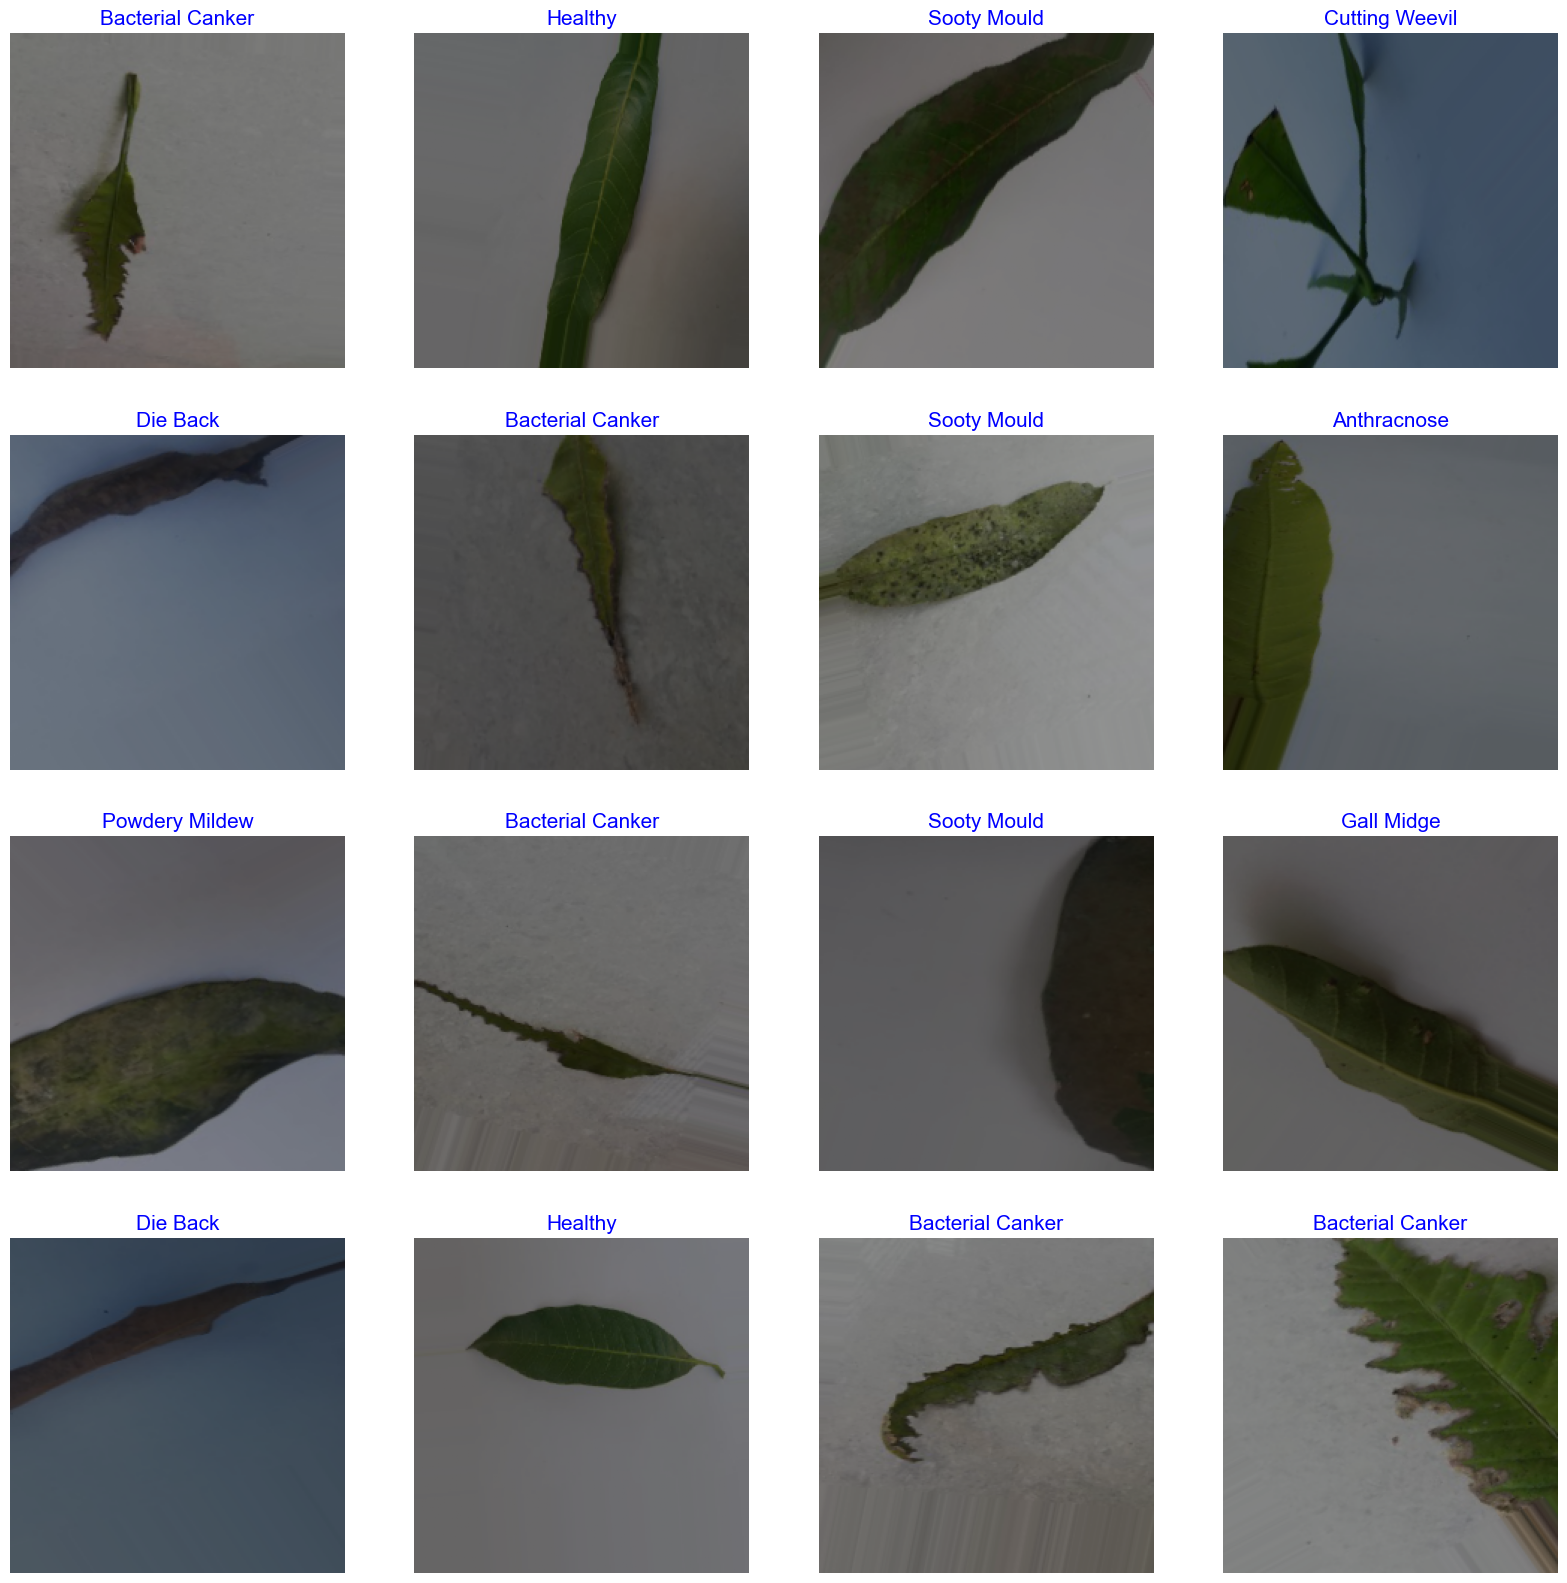

In [24]:
g_dict = train_gen.class_indices      # mendefinisikan dictionary  {'class': index}
classes = list(g_dict.keys())       # mendefinisikan daftar keys dictionary's (kelas), nama kelas : string
images, labels = next(train_gen)      # mendapatkan sampel ukuran batch dari generator

plt.figure(figsize= (20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # menskalakan data ke kisaran (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get index gambar
    class_name = classes[index]   # get gambar class
    plt.title(class_name, color= 'blue', fontsize= 15)
    plt.axis('off')

plt.show()

In [25]:
# Struktur Model
# Pembuatan Model Umum(*Generic*)

In [26]:
# Membuat Struktur Model
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # untuk menentukan jumlah kelas dalam lapisan padat

# membuat model yang telah dilatih sebelumnya (atau bisa membuat model yang telah dilatih sebelumnya seperti: efficientnet,
# VGG, Resnet)
# kita akan menggunakan efficientnetb7 dari keluarga EfficientNet.

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False,
                                                               weights= "imagenet",
                                                               input_shape= img_shape,
                                                               pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128,
          kernel_regularizer= regularizers.l2(l2= 0.016),  # Ganti 'l' dengan 'l2'
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation = 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 2560)                │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2560)                │          10,240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,436,767 (245.81 MB)

 Trainable params: 333,960 (1.27 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

In [27]:
# Menentukan *Early Stop*

In [28]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               mode='min',
                              )

In [29]:
# *Train*/melatih Model

In [30]:
batch_size = 32   # mengatur ukuran batch untuk training
epochs = 20   # jumlah semua dari epochs training

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen,
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 463s 6s/step - accuracy: 0.3860 - loss: 16.3511 - val_accuracy: 0.6017 - val_loss: 8.6019
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 434s 6s/step - accuracy: 0.4667 - loss: 7.2058 - val_accuracy: 0.4217 - val_loss: 5.5301
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 415s 6s/step - accuracy: 0.3422 - loss: 5.4707 - val_accuracy: 0.3083 - val_loss: 5.1021
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step - accuracy: 0.2526 - loss: 5.0715 - val_accuracy: 0.2683 - val_loss: 4.8435
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 415s 6s/step - accuracy: 0.2298 - loss: 4.7995 - val_accuracy: 0.2800 - val_loss: 4.6044
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step - accuracy: 0.2370 - loss: 4.5519 - val_accuracy: 0.2450 - val_loss: 4.3637
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 414s 6s/step - accuracy: 0.2096 - loss: 4.3254 - val_accuracy: 0.2517 - val_loss: 4.1417
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step - accuracy: 0.2142 - loss: 4.0991 - val_accuracy: 0.2550 - 

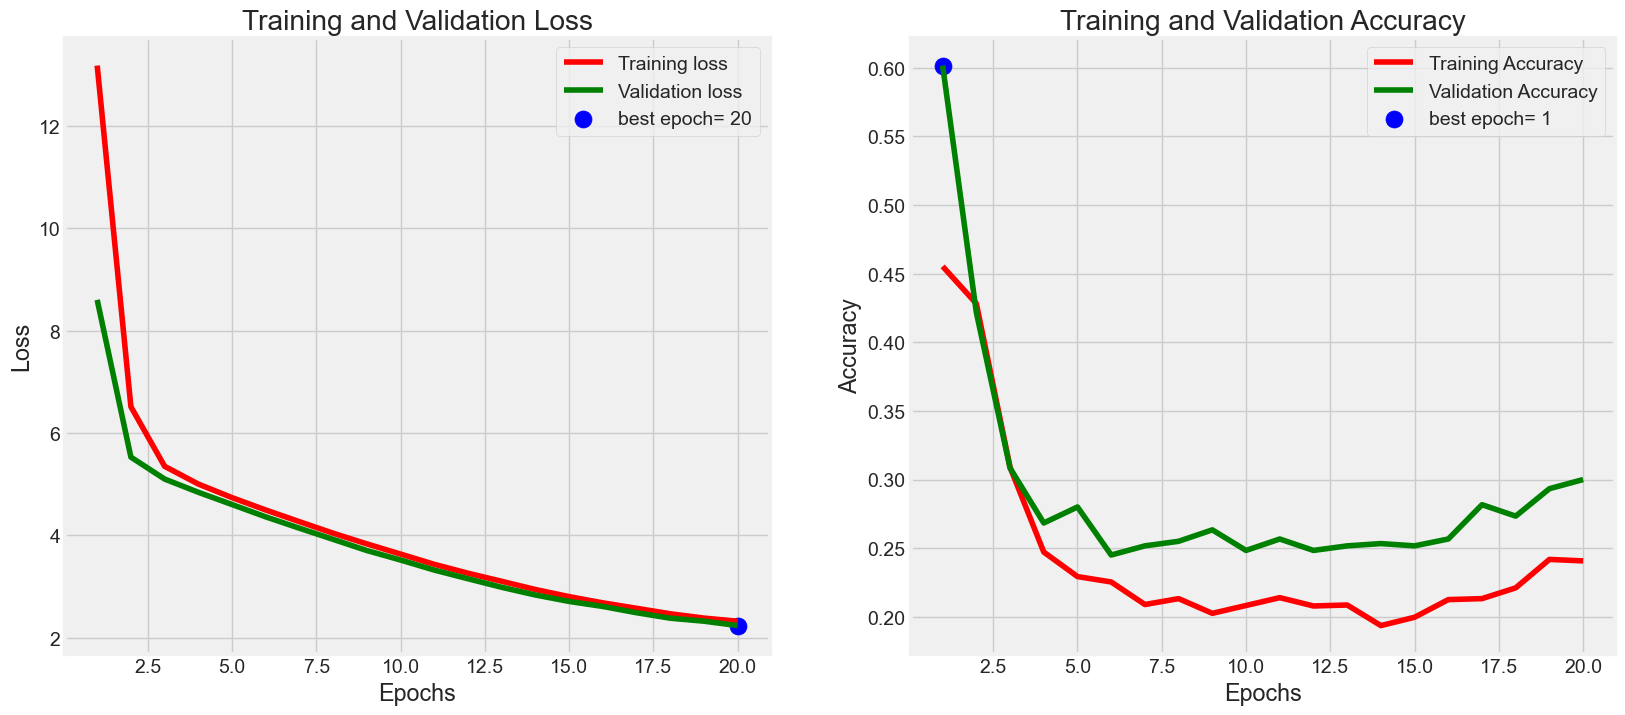

In [31]:
# Menentukan variabel yang dibutuhkan
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot riwayat pelatihan(*Training History*)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [32]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.3443 - loss: 2.2526
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.3045 - loss: 2.2260
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step - accuracy: 0.3303 - loss: 2.3151
Train Loss:  2.244490623474121
Train Accuracy:  0.34687501192092896
--------------------
Validation Loss:  2.2347705364227295
Validation Accuracy:  0.29374998807907104
--------------------
Test Loss:  2.3188490867614746
Test Accuracy:  0.3233333230018616


In [34]:
# Menggunakan predict langsung
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Menampilkan hasil prediksi
print("Hasil Prediksi:", y_pred)


8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 9s/step
Hasil Prediksi: [0 2 2 4 0 4 0 4 4 2 2 4 4 2 2 4 2 0 4 4 4 4 4 4 4 4 0 4 4 0 4 4 4 4 0 4 4
 2 2 4 4 4 4 4 4 4 4 4 0 4 4 4 4 0 0 2 4 4 2 4 4 4 4 4 4 4 0 0 4 4 2 0 4 4
 4 4 4 4 4 4 2 4 4 4 4 2 4 4 4 4 2 4 2 2 4 4 4 2 0 4 0 4 4 4 0 2 4 0 0 4 4
 4 0 2 4 4 4 4 4 4 2 2 4 4 4 2 4 4 4 4 0 4 4 4 4 2 4 2 4 4 2 4 4 4 4 4 4 4
 2 4 4 0 0 0 4 4 4 4 0 4 2 2 4 4 4 4 4 4 4 4 4 2 0 2 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 2 4 4 0 2 2 4 4 4 4 4 4 2 4 2 4 4 2 4 4 4 2 0 4 4 2 4 3 4 2 3 4 4 4
 0 4 4 2 4 4 0 4 4 4 4 4 2 4 2 4 4 4 4 4 2 2 4 4 4 4 4 2 4 4 4 4 2 0 4 4 2
 0 4 4 0 4 2 4 0 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 2 4 0 4 4
 4 4 4 4 4 2 4 4 2 4 4 4 4 4 4 4 4 4 4 4 0 2 4 4 4 4 4 4 0 2 4 4 4 4 4 2 4
 2 4 4 4 4 4 4 5 4 4 2 2 2 4 4 4 4 0 4 4 4 4 2 2 0 4 4 4 2 4 0 4 4 0 0 4 0
 4 4 4 4 4 0 4 4 4 4 4 0 4 4 4 4 0 4 2 4 4 4 4 4 4 4 0 0 2 4 4 4 4 4 4 4 4
 4 0 2 4 4 4 4 4 4 0 4 4 4 4 4 0 4 0 4 4 4 4 4 4 4 4 2 2 4 4 0 4 4 4 2 4 4
 4 2 4 4 4 4 4 4 4 4 2 4 4 4 4 4 0 4 4 4 4 2 4 

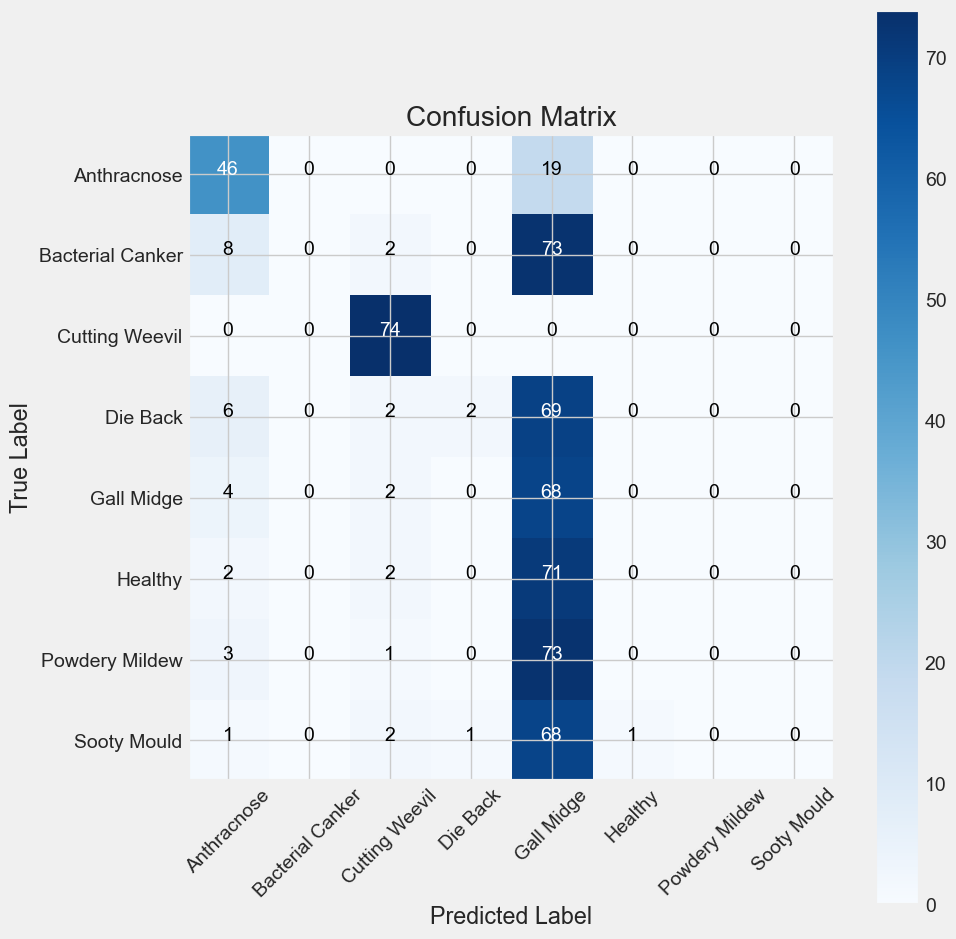

In [35]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

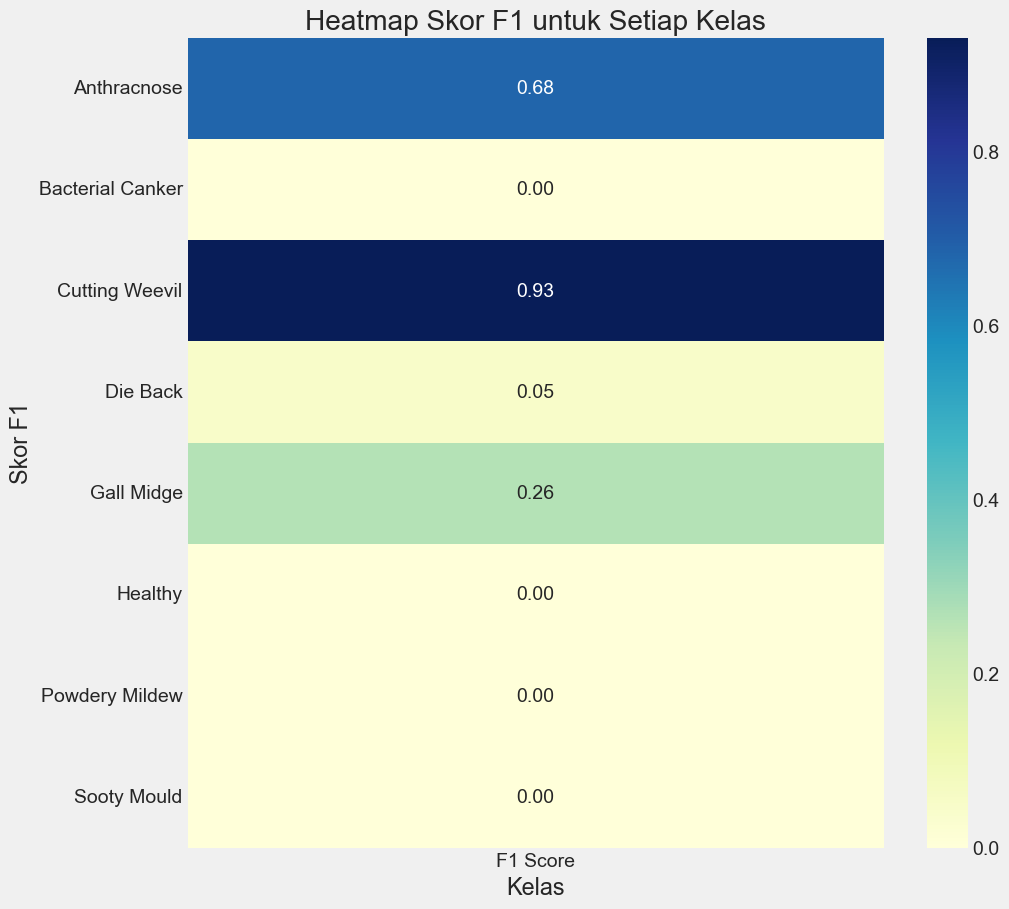

In [36]:
from sklearn.metrics import f1_score
# Menghitung skor F1
f1_scores = f1_score(test_gen.classes, y_pred, average=None)

# Membuat DataFrame untuk heatmap
f1_df = pd.DataFrame(f1_scores, index=classes, columns=['F1 Score'])

# Membuat heatmap
plt.figure(figsize=(10,10))
sns.heatmap(f1_df, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap Skor F1 untuk Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Skor F1')
plt.show()

In [37]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       0.66      0.71      0.68        65
Bacterial Canker       0.00      0.00      0.00        83
  Cutting Weevil       0.87      1.00      0.93        74
        Die Back       0.67      0.03      0.05        79
      Gall Midge       0.15      0.92      0.26        74
         Healthy       0.00      0.00      0.00        75
  Powdery Mildew       0.00      0.00      0.00        77
     Sooty Mould       0.00      0.00      0.00        73

        accuracy                           0.32       600
       macro avg       0.29      0.33      0.24       600
    weighted avg       0.29      0.32      0.23       600



In [39]:
model.save_weights('my_model_weights-v1.weights.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


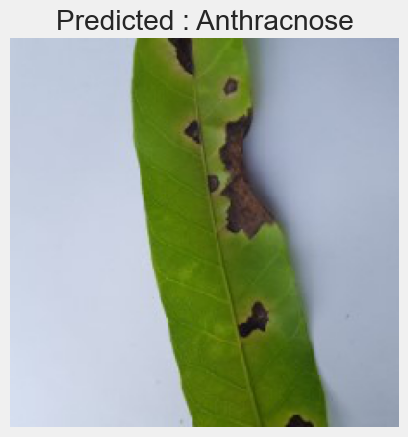

In [44]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted : {predicted_class_label}")
    plt.show()

# Memuat model yang telah dilatih
model.load_weights('C:/Users/USER\PM/PROJECT ML/code/my_model_weights-v1.weights.h5')

# Tentukan label kelas nya (misalnya, ['mobil', 'truk', ...])
class_labels = list(train_gen.class_indices.keys())

# Ganti 'path_to_test_image' mengarah ke lokasi ke gambar yang akan di uji berada
image_path_to_test = 'C:/Users/USER/PM/PROJECT ML/foto/20211011_134644 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)